In [1]:
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n

In [2]:
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans

In [3]:
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
warnings.filterwarnings('ignore')

In [5]:
%load_ext autoreload
%autoreload 2
from notebook_functions import *
%matplotlib inline

In [6]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

# Read in Data and Prepare Variables

In [7]:
duke_v2_with_strateos_80 = pd.read_csv("experiment_data/processed/duke_v2_with_strateos_80.csv")


In [8]:
duke_v2_with_strateos_80[n.inducer_concentration].unique()

array([ 0.,  5., 10., 15., 20., 80.])

In [9]:
duke_v2_with_strateos_80 = duke_v2_with_strateos_80.loc[duke_v2_with_strateos_80[n.inducer_concentration] != 80.0]



In [10]:
duke_stained = duke_v2_with_strateos_80.loc[duke_v2_with_strateos_80["stain"] == 1]
duke_unstained = duke_v2_with_strateos_80.loc[duke_v2_with_strateos_80["stain"] == 0]

In [11]:
features_unstained = n.morph_cols
features_stained_duke = n.morph_cols + ["YL1-A", "YL1-H", "YL1-W"]

In [12]:
print(features_unstained)
print(features_stained_duke)

['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']
['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'YL1-A', 'YL1-H', 'YL1-W']


In [13]:
duke_stained

,inducer_concentration,timepoint,stain,FSC-A,SSC-A,YL1-A,FSC-H,SSC-H,YL1-H,FSC-W,SSC-W,YL1-W,percent_live,source
0,0.0,0.0,1.0,6.02060,6.02060,4.90093,5.76444,5.41198,2.94052,3.00988,3.00988,0.00000,79.495714,duke_v2
1,0.0,0.0,1.0,5.38945,4.59275,2.59770,5.37109,4.59422,2.41497,1.96379,1.87506,0.00000,79.495714,duke_v2
2,0.0,0.0,1.0,5.45014,4.88310,2.40312,5.41537,4.84833,2.23300,1.94448,1.89763,0.00000,79.495714,duke_v2
3,0.0,0.0,1.0,5.64436,5.11836,2.86629,5.58375,5.06345,2.63849,1.95424,1.94448,0.00000,79.495714,duke_v2
4,0.0,0.0,1.0,5.25856,4.68307,1.80618,5.25983,4.68142,2.18184,1.90309,1.86332,0.00000,79.495714,duke_v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169995,20.0,6.0,1.0,5.08193,4.13165,4.04930,5.09134,4.15503,4.05477,1.83885,1.59106,1.64345,0.000000,duke_v2
1169996,20.0,6.0,1.0,5.22190,4.54565,4.05046,5.20355,4.52742,4.03715,1.87506,1.86923,1.64345,0.000000,duke_v2
1169997,20.0,6.0,1.0,5.43782,4.70509,3.27898,5.35587,4.63210,3.18013,1.95424,1.90309,1.36173,0.000000,duke_v2
1169998,20.0,6.0,1.0,5.37946,4.67435,4.35232,5.32741,4.62707,4.32408,1.92942,1.89209,1.80618,0.000000,duke_v2


# Generate RF Labels for Stained data but only using Morph Features

In [14]:
df_duke_stained_morph, \
X_duke_stained_morph, \
Y_duke_stained_morph = generate_rf_labels_from_conditions(duke_stained,
                                                          features_unstained,
                                                live_conditions=[{'inducer_concentration': 0.0, 'timepoint': 0.0},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 0.5},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 3.0},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 6.0}],
                                                dead_conditions=None
                                                         )

Conditions designated as Live: [{'inducer_concentration': 0.0, 'timepoint': 0.0}, {'inducer_concentration': 0.0, 'timepoint': 0.5}, {'inducer_concentration': 0.0, 'timepoint': 3.0}, {'inducer_concentration': 0.0, 'timepoint': 6.0}]
Conditions designated as Dead: [{'inducer_concentration': 20.0, 'timepoint': 6.0}, {'inducer_concentration': 80.0, 'timepoint': 6.0}]


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 16:15:33
Starting Classification training...
Training time was: 36.25 seconds
Testing time was: 4.59 seconds
Prediction time of untested data was: 20.561174869537354
Run finished at 16:16:39. Total run time = 66.11 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




# All Plots/Models use Stained data, but models only use morph features

**Replacing CFU percent_live values for 0% ethanol at time 0.5 and 1.0 with 100% before feeding into the model**

In [15]:
Y_duke_stained_morph.loc[(Y_duke_stained_morph[n.inducer_concentration] == 0.0) & 
                             (Y_duke_stained_morph[n.timepoint].isin([0.5, 1.0, 5.0])), n.percent_live] = 100.0
# Y_duke_stained_morph


Model Boosting took 234.68401789665222 seconds
Training Accuracy = 65.78%
Counter({1: 317797, 0: 282203})
Instructions for updating:
Please use `model.predict()` instead.


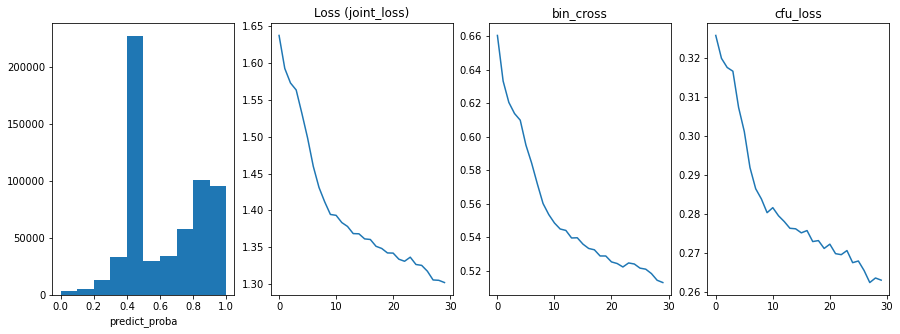

In [16]:
cr_duke_stained_morph, \
pl_duke_stained_morph = run_model(model_function=booster_model_v2, lr=0.001,
                                      loss = joint_loss_wrapper(3), metrics = [bin_cross, cfu_loss],
                                      X = X_duke_stained_morph, Y = Y_duke_stained_morph, 
                                      epochs = 30, batch_size = 2048,
                                      verbose = False, shuffle = True, plot_type="line")

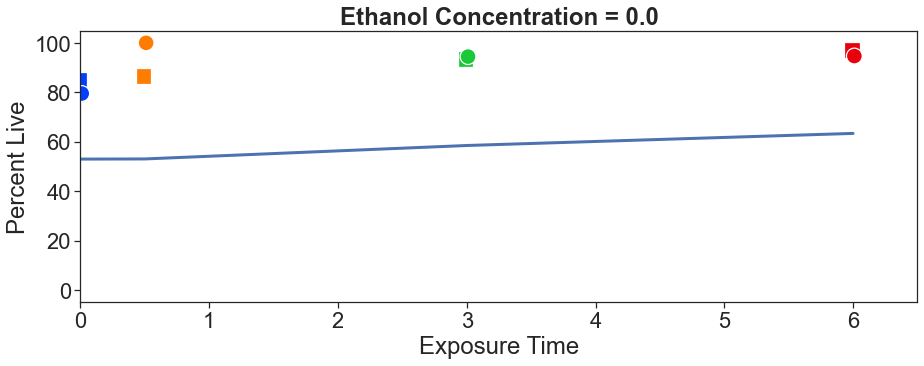

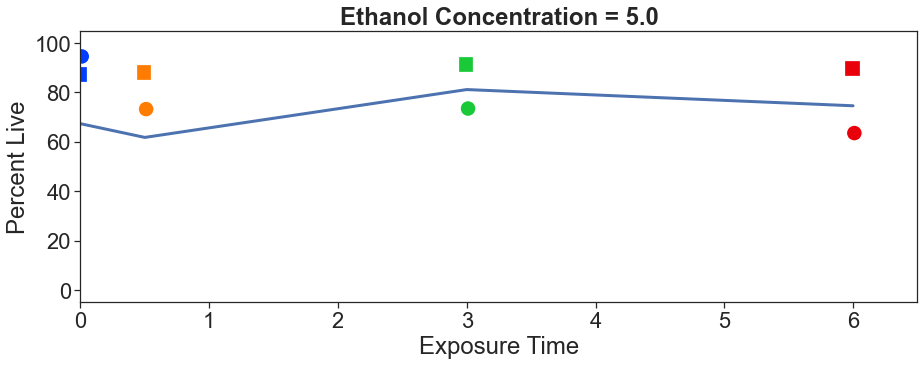

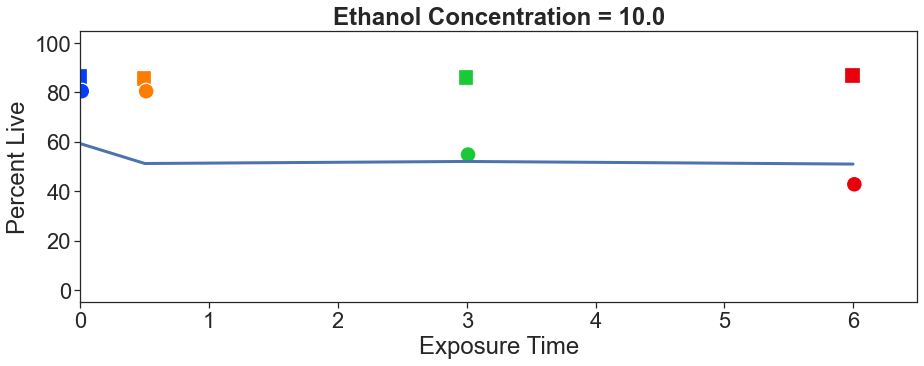

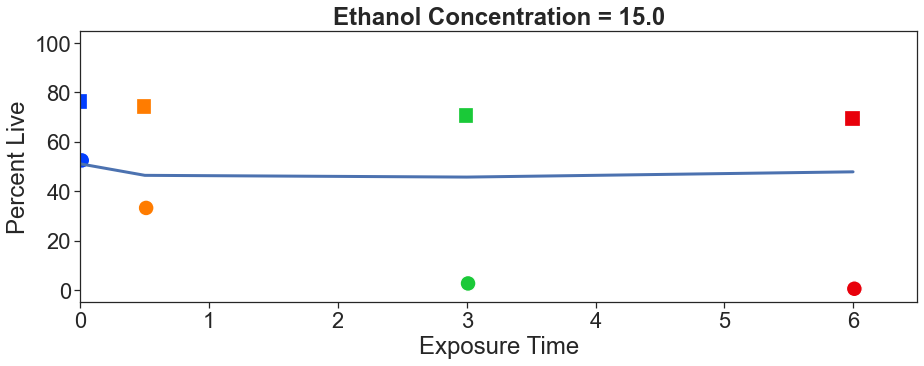

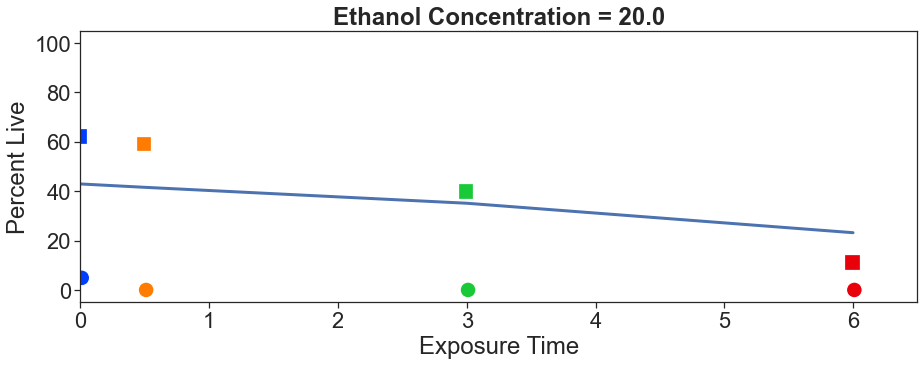

In [17]:
plot_per_cond(cr_duke_stained_morph)

In [18]:
info_duke_stained_morph = get_all_run_info(df_duke_stained_morph, 
                                               X_duke_stained_morph,
                                               pl_duke_stained_morph,
                                               append_df_cols=["YL1-A", "YL1-H", "YL1-W"])

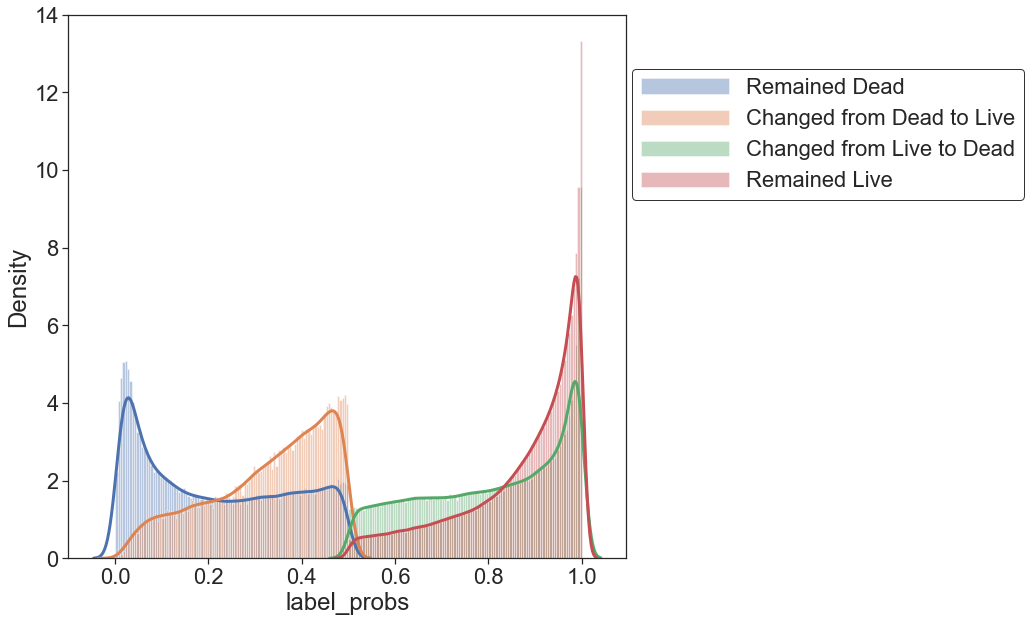

In [19]:
plot_prob_changes(info_duke_stained_morph, None)

# Calculate KDEs to get point density

In [20]:
conc_df_all = get_conc_df_with_kde_values(run_info=info_duke_stained_morph,
                                          conc="all",
                                          features=features_stained_duke,
                                          cc="YL1-H")

# Scatter + KDE Plots

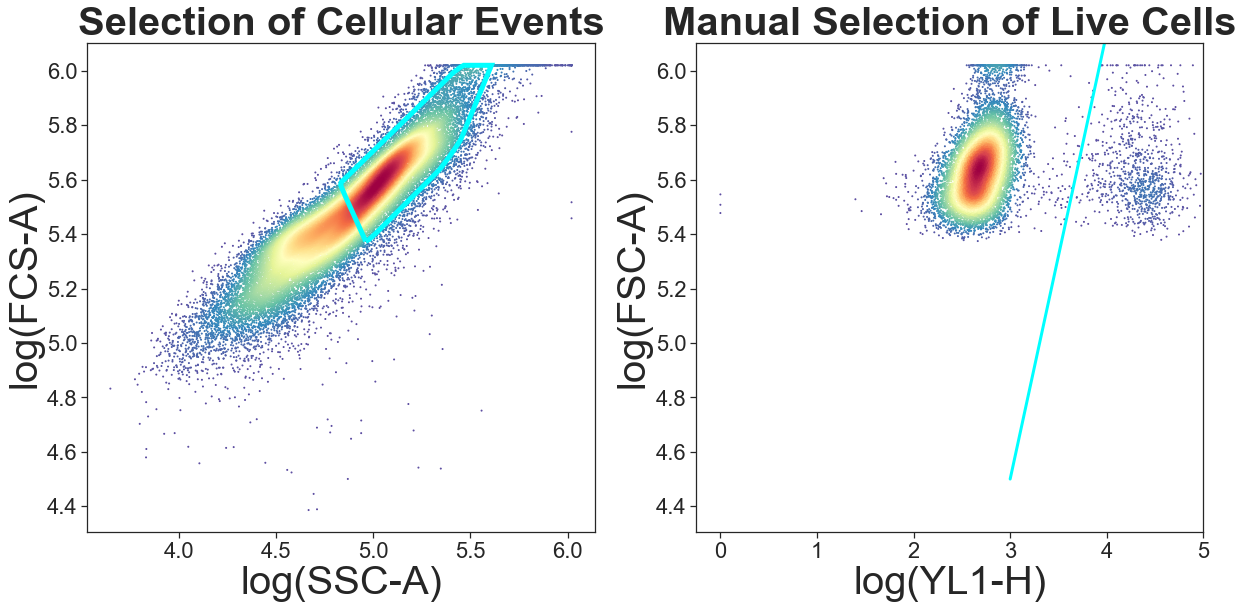

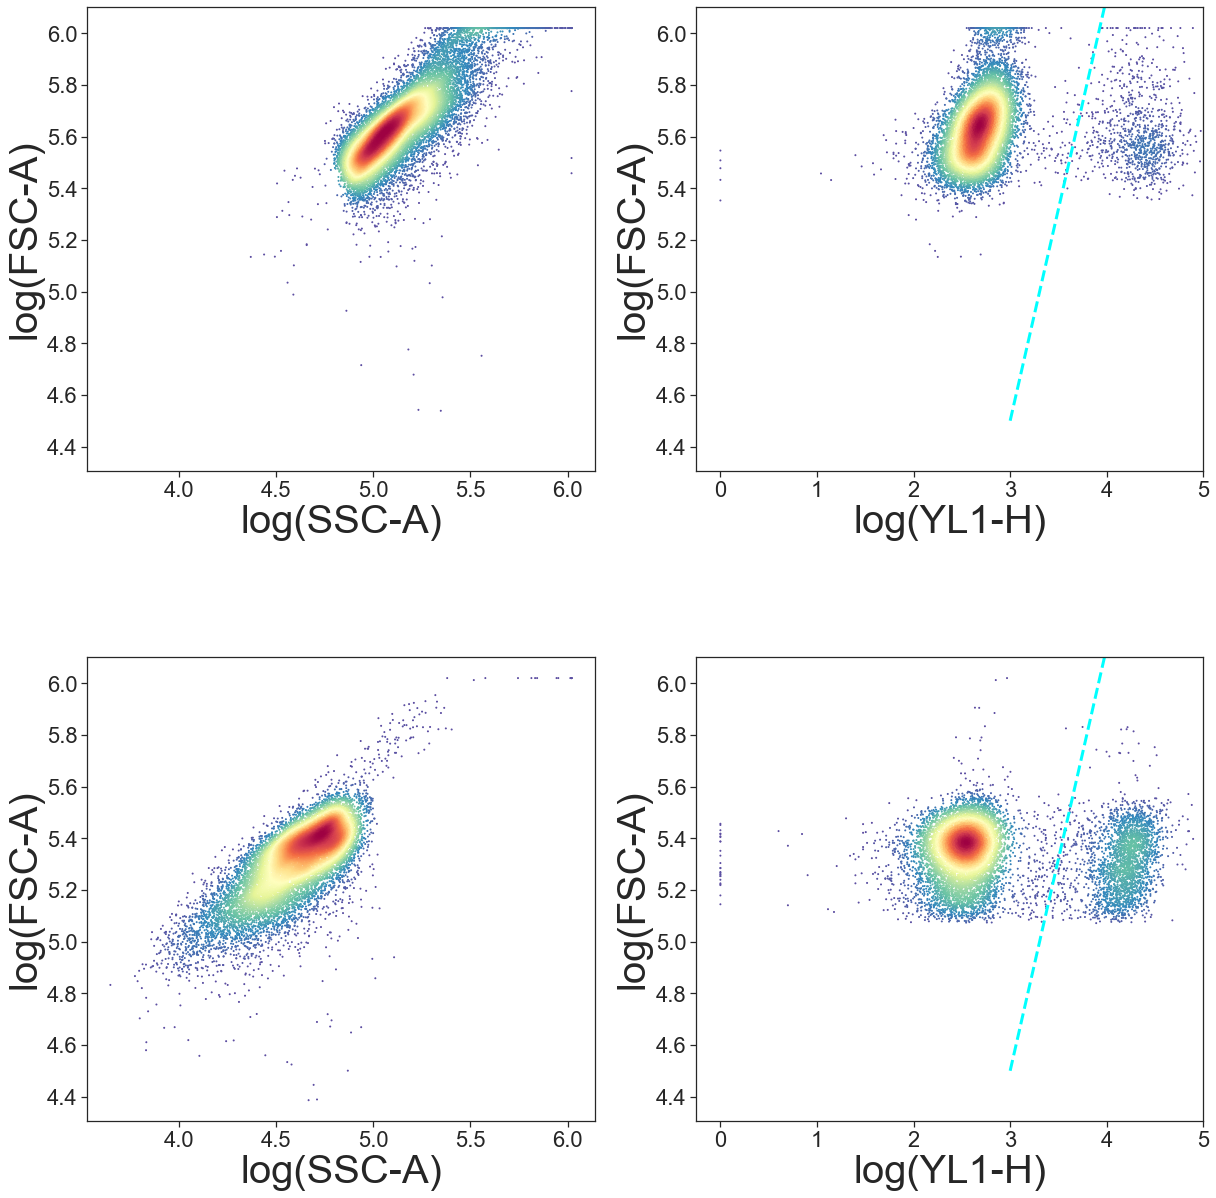

In [21]:
kde_df, kde_df_sub = kde_scatter(conc_df_all, cc="YL1-H", logged=True, subset_ratio=0.85, cmap="Spectral_r",
                     pred_col="nn_preds", pred_display_type="scatter_density", 
                     line_params=([3, 4], [4.5, 6.14]))

In [22]:
# _, _ = kde_scatter(conc_df_all.loc[conc_df_all[n.inducer_concentration]==80.0], cc="YL1-H", logged=True, 
#                    subset_ratio=0.85, cmap="Spectral_r",
#                    pred_col="nn_preds", pred_display_type="scatter_density", 
#                    line_params=([2.4, 3.05], [4, 5.75]))

In [23]:
# _, _ = kde_scatter(conc_df_all.loc[conc_df_all[n.inducer_concentration]!=80.0], cc="YL1-H", logged=True, 
#                    subset_ratio=0.85, cmap="Spectral_r",
#                    pred_col="nn_preds", pred_display_type="scatter_density", 
#                    line_params=([2.4, 3.05], [4, 5.75]))

# Calculate SOA_preds using visual line determined from above plots

In [24]:
kde_df["SOA_preds"] = 0

# get indices of points in kde_df_sub that are above the line drawn above
not_debris = kde_df_sub.loc[kde_df_sub["kmeans"] == 1]  # first need to get upper right ellipse in top-left plot
not_debris["SOA_line"] = 2.6923076923076925 * not_debris["log_YL1-H"] - 2.4615384615384617
not_debris["SOA_preds"] = (not_debris["log_FSC-A"] > not_debris["SOA_line"]).astype(int)
idxs = not_debris.loc[not_debris["SOA_preds"] == 1].index

kde_df.loc[idxs, "SOA_preds"] = 1

## Summary Table

In [25]:
summary_table = kde_df.groupby([n.inducer_concentration, n.timepoint], as_index=False).mean()

name_weakly = "Weakly Supervised Model (RF)"
name_cfu = "CFUs"
name_weakly_boosted = "AutoGater"
name_SOA = "State of the Art"

summary_table.rename(columns={"label": name_weakly, 
                              "cfu_percent_live": name_cfu,
                              "nn_preds": name_weakly_boosted,
                              "SOA_preds": name_SOA}, inplace=True)

summary_table = summary_table[[n.inducer_concentration, n.timepoint, 
                               name_weakly, name_cfu, name_weakly_boosted, name_SOA]]
summary_table = summary_table.loc[summary_table[n.timepoint].isin([0.5, 3.0, 6.0])]
summary_table[name_weakly] = (summary_table[name_weakly]*100).astype(int).astype(str) + "%"
summary_table[name_cfu] = summary_table[name_cfu].astype(int).astype(str) + "%"
summary_table[name_weakly_boosted] = (summary_table[name_weakly_boosted]*100).astype(int).astype(str) + "%"
summary_table[name_SOA] = (summary_table[name_SOA]*100).astype(int).astype(str) + "%"

summary_table[n.inducer_concentration] = summary_table[n.inducer_concentration].astype(str)
summary_table[n.timepoint] = summary_table[n.timepoint].astype(str)
# summary_table.to_csv("summary_table.csv", index=False)

summary_table_styled = summary_table.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
summary_table_styled.set_properties(**{'text-align': 'center'}).hide_index()

summary_table_styled

inducer_concentration,timepoint,Weakly Supervised Model (RF),CFUs,AutoGater,State of the Art
0.0,0.5,85%,100%,53%,42%
0.0,3.0,93%,94%,61%,34%
0.0,6.0,97%,94%,61%,32%
5.0,0.5,88%,73%,60%,36%
5.0,3.0,91%,73%,81%,15%
5.0,6.0,90%,63%,74%,24%
10.0,0.5,86%,80%,51%,42%
10.0,3.0,86%,54%,52%,40%
10.0,6.0,87%,42%,53%,41%
15.0,0.5,76%,33%,44%,39%


In [26]:
summary_table

,inducer_concentration,timepoint,Weakly Supervised Model (RF),CFUs,AutoGater,State of the Art
1,0.0,0.5,85%,100%,53%,42%
2,0.0,3.0,93%,94%,61%,34%
3,0.0,6.0,97%,94%,61%,32%
5,5.0,0.5,88%,73%,60%,36%
6,5.0,3.0,91%,73%,81%,15%
7,5.0,6.0,90%,63%,74%,24%
9,10.0,0.5,86%,80%,51%,42%
10,10.0,3.0,86%,54%,52%,40%
11,10.0,6.0,87%,42%,53%,41%
13,15.0,0.5,76%,33%,44%,39%


In [27]:
concat_summary_table = pd.concat([summary_table[["inducer_concentration",
                                                 "timepoint", "CFUs"]].assign(model='CFUs'), 
                                  summary_table[["inducer_concentration",
                                                 "timepoint", "AutoGater"]].assign(model='AutoGater'),
                                  summary_table[["inducer_concentration",
                                                 "timepoint", "State of the Art"]].assign(model='State of the Art')])
concat_summary_table.rename(columns={"CFUs": "percent"}, inplace=True)

concat_summary_table['percent'].update(concat_summary_table.pop('AutoGater'))
concat_summary_table['percent'].update(concat_summary_table.pop('State of the Art'))
concat_summary_table["timepoint"] = concat_summary_table["timepoint"].astype(float)
concat_summary_table["percent"] = concat_summary_table["percent"].str.rstrip('%').astype('float')

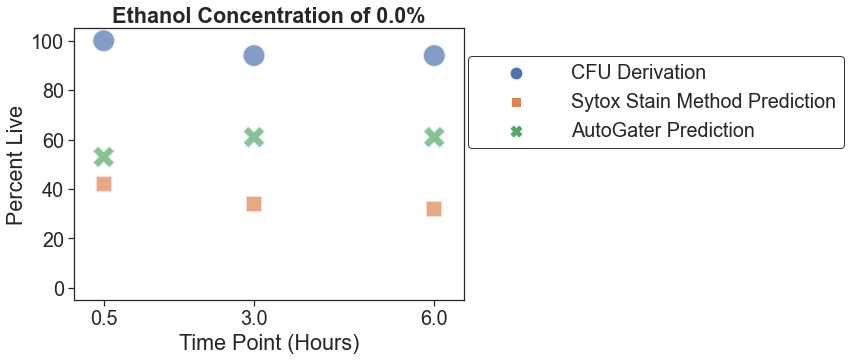

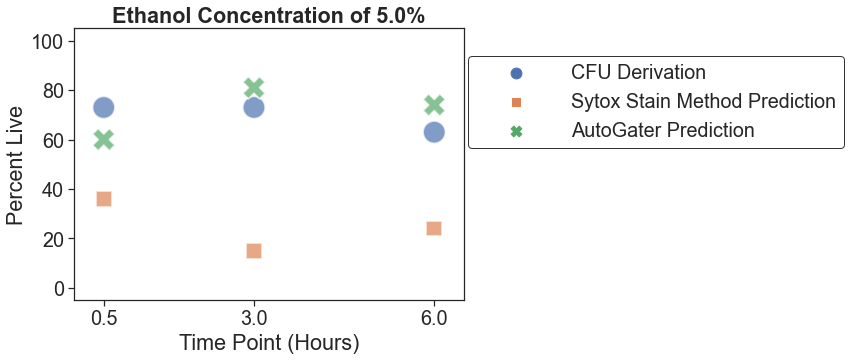

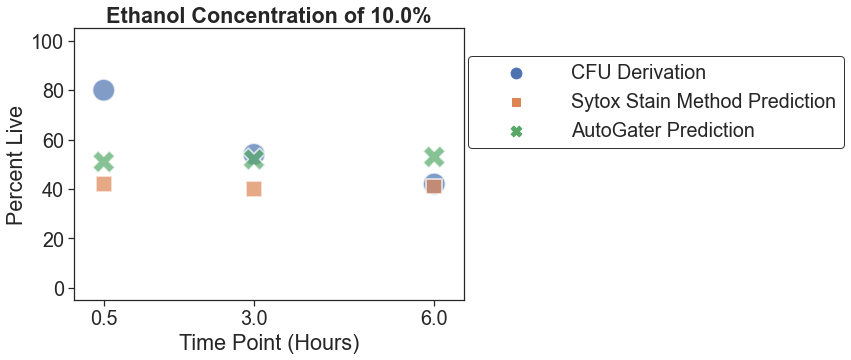

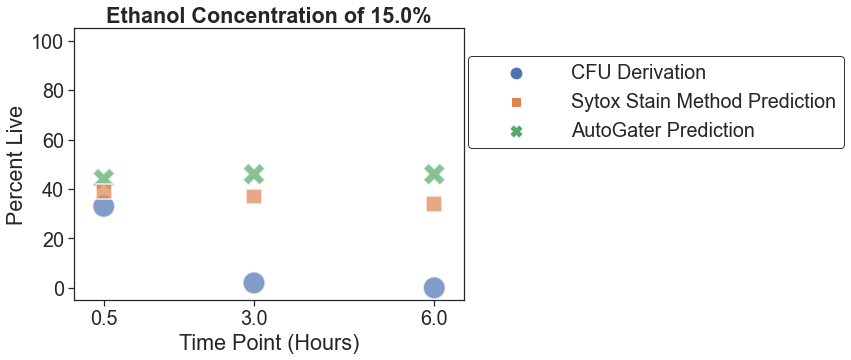

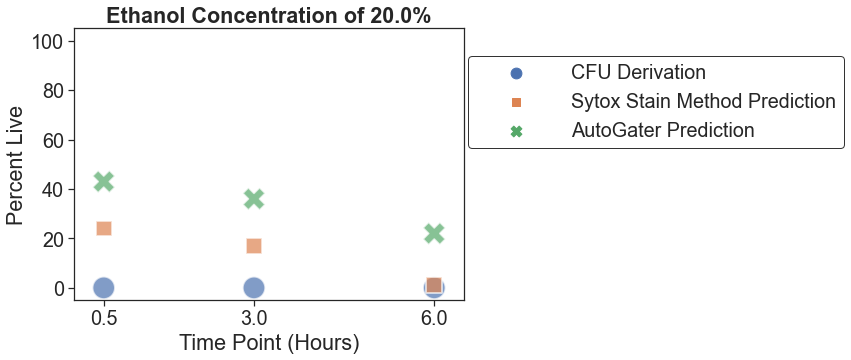

In [28]:
sns.set(style="ticks", font_scale=1.8, rc={"lines.linewidth": 3.0})

for c in [str(x) for x in list(concat_summary_table[n.inducer_concentration].unique())]:
    plt.figure(figsize=(7, 5))

    sc = sns.scatterplot(data=concat_summary_table.loc[concat_summary_table["inducer_concentration"] == c], 
                         x="timepoint", y="percent", s=500, alpha=.7, style="model",
                         hue="model", hue_order=["CFUs", "State of the Art", "AutoGater"], legend="full")

    legend = plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0.,
                        handlelength=4, markerscale=1.8)
    legend.get_frame().set_edgecolor('black')
    new_labels = ['CFU Derivation', 'Sytox Stain Method Prediction', 'AutoGater Prediction']
    for t, l in zip(legend.texts, new_labels): t.set_text(l)

    sc.set(xlim=(0, 6.5), xlabel="Time Point (Hours)",
           ylim=(-5, 105), ylabel="Percent Live",
           xticks=[0.5, 3, 6])
    sc.set_title("Ethanol Concentration of {}%".format(c), fontweight="bold")
    plt.show()